In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [3]:
generation_source=pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', sep=';', decimal=',', parse_dates=True)
generation_nandrop=generation_source.dropna()

temperature_source=pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', sep=';', decimal=',', parse_dates=True)
temperature_nandrop=temperature_source.drop(temperature_source.tail(95).index)

merged=temperature_nandrop.merge(generation_nandrop, on='DateTime', how='left')

merged['DateTime']=pd.to_datetime(merged['DateTime'])

merged['Generation'] = np.log1p(merged["Generation"].values)

#df=create_time_features(df)

merged["WWCode"].fillna(method='ffill',inplace=True)

#Thanks to other partipiciant's work I know exactly how to deal with this feature (reference link at the end of the notebook)
merged['WWCode']=merged['WWCode'].replace([84], 83)

#saving copies
datetime_copy=merged['DateTime']
merged_with_dt_as_column=merged
merged=merged.set_index('DateTime')
merged.index.freq='H'

# normalizing
#merged['WindDirection']=merged['WindDirection']/10
#merged['WWCode']=merged['WWCode']/10

merged

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation
DateTime,,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0.000000
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,0.000000
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,0.000008
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,0.000000
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,0.000008
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,8.9,8.4,62.0,0.0,0.0,2.0,1.5,NaN
2021-12-31 20:00:00,8.0,7.6,65.9,0.0,0.0,2.0,1.5,NaN
2021-12-31 21:00:00,7.3,6.9,70.1,0.0,0.0,6.0,1.5,NaN


In [4]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       26304 non-null  float64
 1   ComfortTemperature   26304 non-null  float64
 2   RelativeHumidity     26304 non-null  float64
 3   WindSpeed            26304 non-null  float64
 4   WindDirection        26304 non-null  float64
 5   WWCode               26304 non-null  float64
 6   EffectiveCloudCover  26304 non-null  float64
 7   Generation           25560 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


In [5]:
#training data
df_for_training=merged.drop(merged.tail(31*24).index)

# hyperparameters
LEARNING_RATE=1e-3
DECAY=1e-5
MAX_EPOCHS=5
BATCH_SIZE=100
VALID_SPLIT=0.2
PATIENCE=10

n_future=1*24
n_past=1*24

scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

#creating the required shape for LSTM network (samples (rows), timesteps, features (columns))
trainX=[]
trainY=[]

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY=np.array(trainX), np.array(trainY)

#model architecture
model=Sequential()

model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1))

#optimizing and training
opt=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
early_stopping=tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)

history=model.fit(trainX, trainY,
        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                 callbacks=[early_stopping], verbose=1)


#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#y2 = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#model.fit(partial_x_train, partial_y_train, epochs=Numepochs, batch_size=Batchsize, validation_data=(x_val, y_val))

2022-02-19 20:58:42.693548: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-19 20:58:44.198690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
205/205 [==============================] - 48s 179ms/step - loss: 0.5988 - mse: 0.5988 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 2/5
205/205 [==============================] - 34s 168ms/step - loss: 0.1678 - mse: 0.1678 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 3/5
205/205 [==============================] - 37s 179ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/5
205/205 [==============================] - 36s 174ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/5
205/205 [==============================] - 37s 179ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0054 - val_mse: 0.0054


Minimum Validation Loss: 0.0054


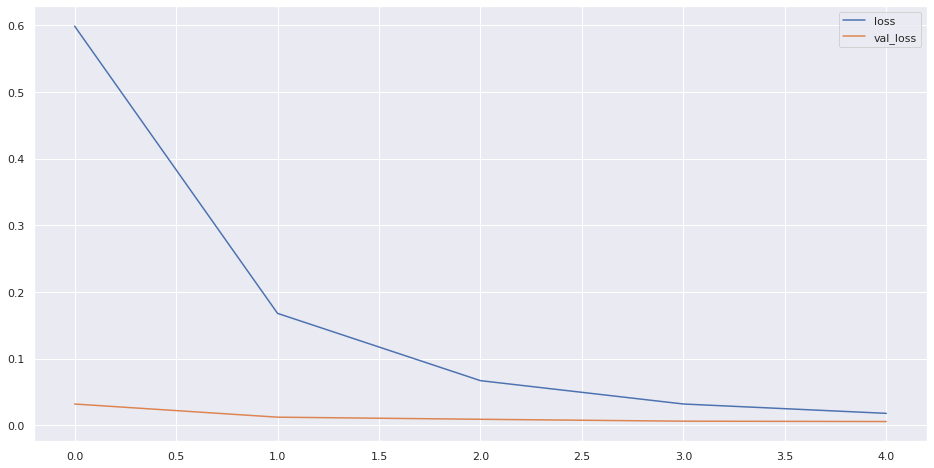

In [6]:


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(16,8))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

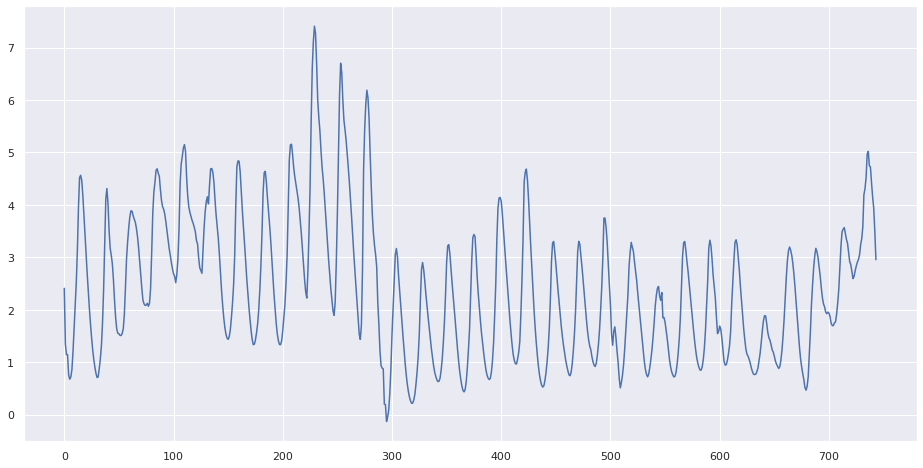

In [7]:
n_hours_for_prediction=24*31 

forecast=model.predict(trainX[-n_hours_for_prediction:])

forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

k=df_for_training.Generation.mean()/y_pred_future.mean()
y_pred_future=k*y_pred_future
plt.figure(figsize=(16,8))
plt.plot(y_pred_future)

In [8]:
from sklearn.metrics import mean_squared_error
rmse_score = np.sqrt(mean_squared_error(trainY[-n_hours_for_prediction:], y_pred_future))

score_list = []
score_list.append(rmse_score)


print(score_list)
print("RMSE Score: ", np.mean(score_list))

[2.3842906817318785]
RMSE Score:  2.3842906817318785


In [9]:
submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission['Generation'] = y_pred_future
submission.to_csv('submission.csv', index=False)
print("Submission File Created")

Submission File Created
